# Example of how to use Plenoptic tools with a torchvision model 



## Setting up Inception v3

In [1]:
import plenoptic as po
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import torch.nn as nn

# Load the pre-trained Inception v3 model
inception = models.inception_v3(pretrained=True, transform_input=False)

# Set the model to evaluation mode
inception.eval()
po.tools.remove_grad(inception)


# Define a new model that stops at the 'pool3' layer that is commonly used for FID

# note this is a very manual way to do this, and there are more elegant ways to do this
# for example, you can use nn.Sequential to create a new model that only includes the layers you want
# or you can use the forward hooks to extract the features from the desired layer
# class InceptionV3FID(nn.Module):
#     def __init__(self, original_model):
#         super().__init__()
#         # Extract the layers up to (and including) pool3
#         self.features = nn.Sequential(
#             original_model.Conv2d_1a_3x3,
#             original_model.Conv2d_2a_3x3,
#             original_model.Conv2d_2b_3x3,
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             original_model.Conv2d_3b_1x1,
#             original_model.Conv2d_4a_3x3,
#             nn.MaxPool2d(kernel_size=3, stride=2),
#             original_model.Mixed_5b,
#             original_model.Mixed_5c,
#             original_model.Mixed_5d,
#             original_model.Mixed_6a,
#             original_model.Mixed_6b,
#             original_model.Mixed_6c,
#             original_model.Mixed_6d,
#             original_model.Mixed_6e,
#             original_model.Mixed_7a,
#             original_model.Mixed_7b,
#             original_model.Mixed_7c,
#             nn.AdaptiveAvgPool2d((1, 1)),  # Pool3 layer output, shape
#         )

#     def forward(self, x):
#         x = self.features(x)
#         return torch.flatten(x, 1)  # Flatten to (batch_size, 2048)


# # Create the truncated model
# inception_fid = InceptionV3FID(inception)

# # Print the architecture (optional)
# print(inception_fid)

# # Example usage with a batch of images (assuming input is normalized correctly)
# dummy_input = torch.randn(8, 3, 299, 299)  # Batch of 8 random images
# with torch.no_grad():
#     features = inception_fid(dummy_input)  # Extract features from pool3
#     print(features.shape)  # Output: (8, 2048)


/mnt/home/hdettki/.virtualenvs/plenoptic/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/home/hdettki/.virtualenvs/plenoptic/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### How to Find the Desired Layer of which we want the model's representation

To attach a hook, we first need to identify the layer of interest in our model. Here’s how to do it:

1. **Load the Model**: Start by loading a pre-trained model (e.g., Inception v3).
   ```python
   import torchvision.models as models
   inception = models.inception_v3(pretrained=True)


We list all layers and modules of the model to identify where to "chop off" the model: 
Use named_modules() to explore all layers and their names in the model.




In [2]:
# List all modules with their names
for name, module in inception.named_modules():
    print(name, "->", type(module))


 -> <class 'torchvision.models.inception.Inception3'>
Conv2d_1a_3x3 -> <class 'torchvision.models.inception.BasicConv2d'>
Conv2d_1a_3x3.conv -> <class 'torch.nn.modules.conv.Conv2d'>
Conv2d_1a_3x3.bn -> <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
Conv2d_2a_3x3 -> <class 'torchvision.models.inception.BasicConv2d'>
Conv2d_2a_3x3.conv -> <class 'torch.nn.modules.conv.Conv2d'>
Conv2d_2a_3x3.bn -> <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
Conv2d_2b_3x3 -> <class 'torchvision.models.inception.BasicConv2d'>
Conv2d_2b_3x3.conv -> <class 'torch.nn.modules.conv.Conv2d'>
Conv2d_2b_3x3.bn -> <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
maxpool1 -> <class 'torch.nn.modules.pooling.MaxPool2d'>
Conv2d_3b_1x1 -> <class 'torchvision.models.inception.BasicConv2d'>
Conv2d_3b_1x1.conv -> <class 'torch.nn.modules.conv.Conv2d'>
Conv2d_3b_1x1.bn -> <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
Conv2d_4a_3x3 -> <class 'torchvision.models.inception.BasicConv2d'>
Conv2d_4a_3x3.conv -> <class 

Next, we want to ignore all the layers that come after the desired layer. There are multiple ways to do this and we use  hooks, as it this is a model agnostic method.

### What is a Hook?

In PyTorch, a **hook** is a function that we can attach to a layer (or module) to capture or modify the data flowing through the model during the **forward** or **backward pass**. Hooks are particularly useful for:

- Extracting intermediate outputs for analysis (what we want), and also for 
- debugging by inspecting activations and gradients.

### Types of Hooks

1. **Forward Hook**: Captures data during the forward pass --> what we need
2. **Backward Hook**: Captures gradients during the backward pass.

Next

In [3]:
# A dictionary to store the output from a specific layer
layer_outputs = {}


# Register a forward hook to capture output from the pool3 layer
def get_intermediate_output(name):
    def hook(module, input, output):
        layer_outputs[name] = output

    return hook


# Attach the hook to the desired layer (adaptive average pooling) and we call it 'pool3'
inception.avgpool.register_forward_hook(get_intermediate_output("pool3"))


Now we can look at the shape and output of our desired level based on some dummy input

In [4]:
# Example input
dummy_input = torch.randn(8, 3, 299, 299)

# Forward pass through the model
with torch.no_grad():
    _ = inception(dummy_input)  # The hook will save the output in layer_outputs

# Access the captured output
pool3_features = layer_outputs["pool3"].view(8, -1)  # Flatten to (8, 2048)
print(pool3_features.shape)  # Output: (8, 2048)

torch.Size([8, 2048])


In [5]:
pool3_features

tensor([[0.1993, 0.5065, 0.0078,  ..., 0.1790, 0.0777, 0.1454],
        [0.1507, 0.4297, 0.0014,  ..., 0.4025, 0.1235, 0.2595],
        [0.1704, 0.3864, 0.0028,  ..., 0.0853, 0.0836, 0.3846],
        ...,
        [0.1557, 0.2370, 0.0084,  ..., 0.1059, 0.0790, 0.3237],
        [0.1608, 0.3800, 0.0135,  ..., 0.1431, 0.0451, 0.2856],
        [0.1688, 0.2602, 0.0054,  ..., 0.0632, 0.1867, 0.1759]])

### Let's explore the model features of the pool3 layer with some example images
For this we need to respect the model's requirements regarding its input shape. In this case, 
the model expects input images normalized, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 299. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [6]:
# Download an example image from the pytorch website
import urllib

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try:
    urllib.URLopener().retrieve(url, filename)
except:
    urllib.request.urlretrieve(url, filename)

# bring the image into the correct format
from PIL import Image
from torchvision import transforms

input_image = Image.open(filename)
preprocess = transforms.Compose(
    [
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model
print(input_batch.shape)

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to("cuda")
    inception.to("cuda")

# Forward pass through the model
with torch.no_grad():
    _ = inception(input_batch)  # The hook will save the output in layer_outputs

# Access the captured output
pool3_features = layer_outputs["pool3"].view(256, -1)  # Flatten to (8, 2048)
pool3_features.shape

torch.Size([1, 3, 299, 299])


torch.Size([256, 8])

image shape: torch.Size([1, 1, 256, 256])


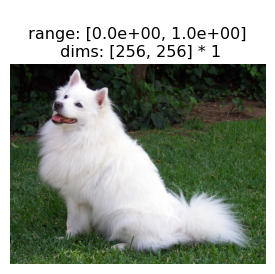

In [7]:
img = po.data.curie()  # curie is too small for inception
print(f"image shape: {img.shape}")
po.imshow(img)
plt.imshow(input_image)

In [8]:
# po.tools.display.plot_representation(data=pool3_features[0])

In [9]:
pool3_features[0].shape

torch.Size([8])

In [10]:
# normalize input batch
input_batch = input_batch.to("cuda")
# normalize the input batch to be between 0 and 1
input_batch = input_batch - input_batch.min()
input_batch = input_batch / input_batch.max()

# met = po.synth.Metamer(input_batch, inception)

In [13]:
class TruncatedInception(nn.Module):
    def __init__(self, original_model):
        super().__init__()
        # Disable the auxiliary classifiers if they exist
        original_model.AuxLogits = None  # Ensure no auxiliary branches interfere
        # Retain the layers up to 'avgpool'
        self.features = nn.Sequential(
            *list(original_model.children())[
                :-2
            ]  # Exclude the last layer (classifier) and the dropout layer right before it
        )
        # Add an explicit adaptive average pooling to maintain correct shape
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        # forward pass through the retained layers
        x = self.features(x)
        # x = self.avgpool(x)  # Ensure pooling to (1, 1) spatial size
        # x = torch.flatten(x, start_dim=1)  # Flatten for expected shape

        return x


# Create the truncated model
truncated_inception = TruncatedInception(inception).to("cuda")

In [18]:
# Example input
dummy_input = torch.randn(8, 3, 299, 299).to("cuda")

# Forward pass through the truncated model
output = truncated_inception(dummy_input)
output.squeeze().shape

torch.Size([8, 2048])

In [20]:
met = po.synth.Metamer(input_batch, truncated_inception)
met.synthesize(store_progress=True, max_iter=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0010643619..1.0011945].
/mnt/home/hdettki/code/plenoptic/src/plenoptic/tools/display.py:927: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


ValueError: min() arg is an empty sequence

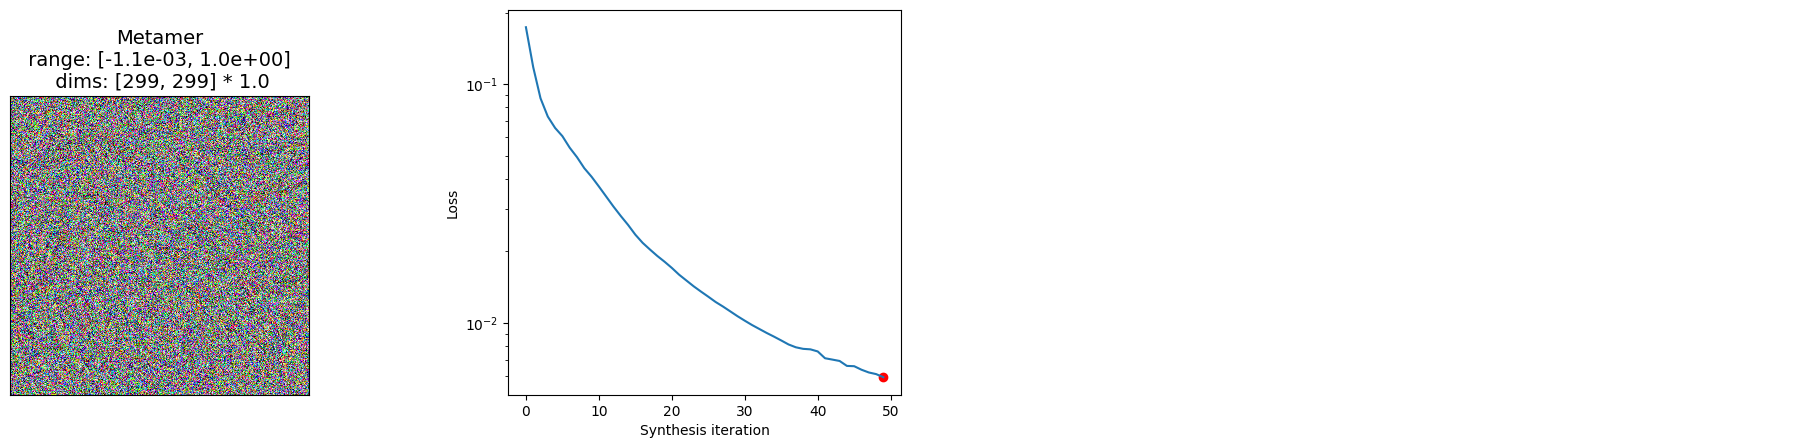

In [21]:
po.synth.metamer.plot_synthesis_status(
    met, width_ratios={"plot_representation_error": 2}
)

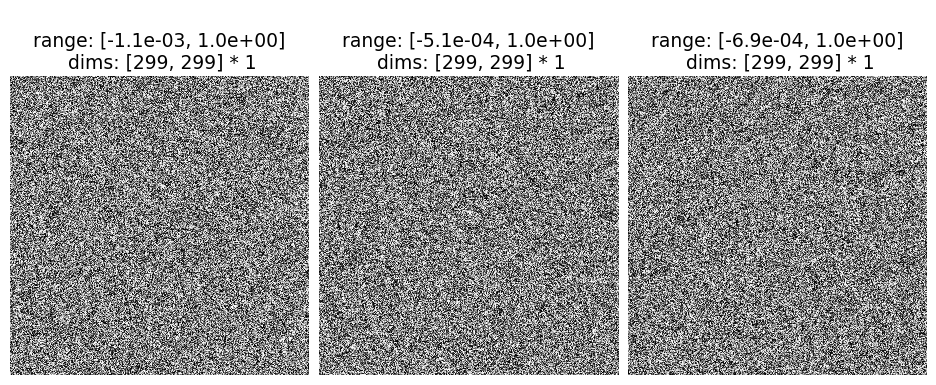

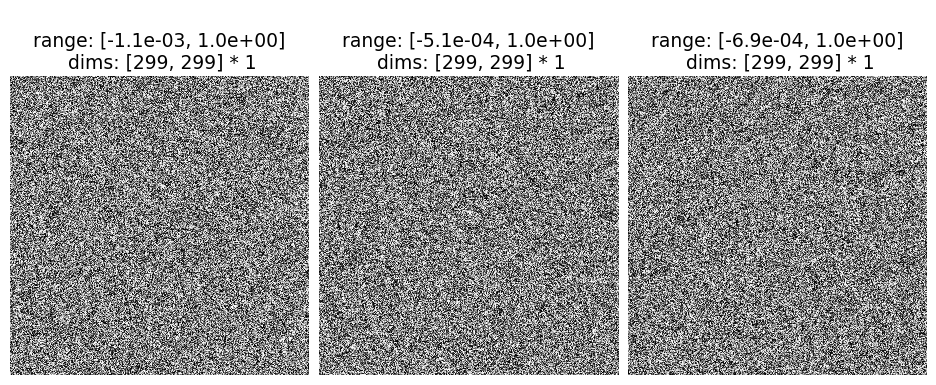

In [28]:
po.imshow(met.metamer)

In [25]:
met